# DDPG PROJECT

Import gym and define pendulum environment

In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt

#env = gym.make('Pendulum-v1', g=9.81, render_mode = 'human')

Check API-conformity

In [2]:
from gym.utils.env_checker import check_env

Import helpers

In [3]:
import helpers

## Heuristic policy

##### Wrap environment in a NormalizedEnv class

In [4]:
env = gym.make('Pendulum-v1', g=9.81)
#env = gym.make('Pendulum-v1', g=9.81, render_mode = 'human')
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<PendulumEnv<Pendulum-v1>>>>>

In [5]:
env = helpers.NormalizedEnv(env)
env

<NormalizedEnv<TimeLimit<OrderEnforcing<PassiveEnvChecker<PendulumEnv<Pendulum-v1>>>>>>

##### RandomAgent

In [6]:
random_agent = helpers.RandomAgent(env)

In [7]:
rewards = np.zeros((10,200))

for i in range(10):
    state = env.reset()
    state = state[0]
    
    trunc = False
    cur_reward = []
    
    while not trunc:   
        action = random_agent.compute_action(state) 
        (next_state, reward, term, trunc, info) = env.step(action)
        state = next_state
        cur_reward.append(reward)
        
        if term or trunc:
            observation, info = env.reset()
    
    rewards[i] = cur_reward

rand_rewards = rewards

##### Heuristic pendulum agent

In [8]:
class HeuristicPendulumAgent:
    def __init__(self, env, t):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.t = t
    def compute_action(self, state):
        if state[0] <= 0:
            return self.t * np.sign(state[2])
        else:
            return -self.t * np.sign(state[2])

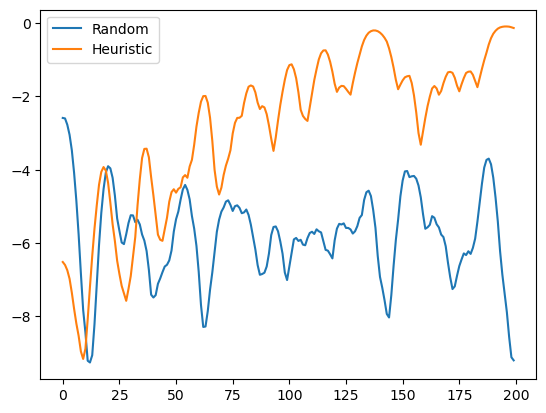

In [9]:
heur_agent = HeuristicPendulumAgent(env,0.8)
rewards = np.zeros((10,200))

#Buffer = ReplayBuffer(max_size = 400)

for i in range(10):
    state = env.reset()
    state = state[0]

    trunc = False
    cur_reward = []

    while not trunc:
        action = heur_agent.compute_action(state) 
        (next_state, reward, term, trunc, info) = env.step(action)
        state = next_state
        cur_reward.append(reward)

        if term or trunc:
            observation, info = env.reset()
            
    rewards[i] = cur_reward

heur_rewards = rewards

plt.figure()
plt.plot(np.arange(200), np.mean(rand_rewards,axis = 0))
plt.plot(np.arange(200), np.mean(heur_rewards, axis = 0))
plt.legend(['Random','Heuristic'])

Effect of fixed torque

Text(0, 0.5, 'Avg. total reward (over 10 runs)')

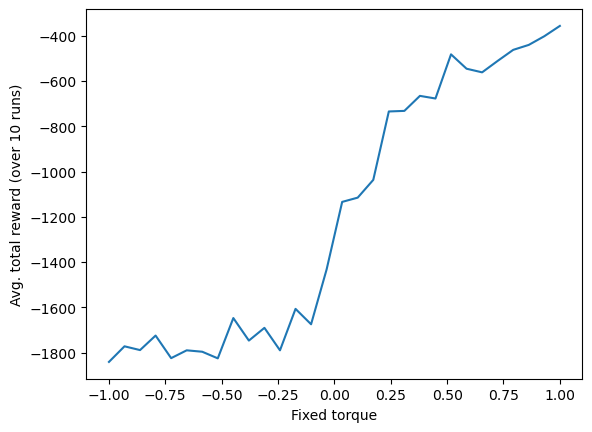

In [10]:
torques = np.linspace(-1,1,30)
avg_rewards = []

for t in torques:
    heur_agent = HeuristicPendulumAgent(env,t)
    rewards = []

    for _ in range(10):
        state = env.reset()
        state = state[0]

        trunc = False
        cur_reward = 0

        while not trunc:
            action = heur_agent.compute_action(state) 
            (next_state, reward, term, trunc, info) = env.step(action)
            state = next_state
            cur_reward += reward

            if term or trunc:
                observation, info = env.reset()

        rewards.append(cur_reward)
    avg_rewards.append(np.mean(rewards))

plt.figure()
plt.plot(torques, avg_rewards)
plt.xlabel('Fixed torque')
plt.ylabel('Avg. total reward (over 10 runs)')

In [11]:
env.close()

# Q function of the heuristic policy

In [12]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = []
        
    def store_transition(self, trans):
        if len(self.buffer)<self.max_size:           
            self.buffer.append(trans)
    
    def batch_buffer(self, batch_size):
        n = len(self.buffer)
        indexes = np.random.permutation(n)[:min(batch_size,self.max_size)]
        return [self.buffer[i] for i in indexes]

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(4, 32)
        self.layer2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.output(x)
        return x

In [14]:
heur_agent = HeuristicPendulumAgent(env,0.8)
max_size = 1e4
Buffer = ReplayBuffer(max_size = max_size)

for _ in range(int(max_size/200)):
    state = env.reset()
    state = state[0]

    trunc = False
    
    while not trunc:
        action = heur_agent.compute_action(state) 
        (next_state, reward, term, trunc, info) = env.step(action)
        Buffer.store_transition((state, action, reward, next_state, trunc))
        state = next_state

        if term or trunc:
            observation, info = env.reset()


In [15]:
def train_epoch(model, agent, optimizer, criterion, gamma, Buffer, epoch, device):
    model.train()
    b = Buffer.batch_buffer(128)
    data = np.zeros((128,4))
    reward = np.zeros(128)
    next_data = np.zeros((128,4))
    trunc = np.zeros(128)
    for i,transition in enumerate(b):        
        data[i] = np.concatenate([transition[0], np.array([transition[1]])])
        reward[i] = transition[2]
        trunc[i] = transition[4]
        next_data[i] = np.concatenate([transition[3], np.array([agent.compute_action(transition[3])])])
    
    data = torch.tensor(data, dtype=torch.float32).to(device)   
    reward = torch.tensor(reward, dtype=torch.float32).to(device)
    next_data = torch.tensor(next_data, dtype=torch.float32).to(device)
    trunc = torch.tensor(trunc, dtype = torch.bool)
    optimizer.zero_grad()
    output = model(data)  # (state, action) -> Q
    with torch.no_grad():
        target = (reward + trunc*model(next_data).flatten()).reshape(128,1)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
    return loss

    

In [ ]:
device = "cpu"
model = QNetwork().to(device)
lr = 1e-4
gamma = 0.99
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.MSELoss()
num_epochs = 1000
history = []
for epoch in range(num_epochs):
    loss = train_epoch(model, heur_agent, optimizer, criterion, gamma, Buffer, epoch, device)
    if epoch%100 == 0:
        print(loss)
    history.append(loss.detach().numpy())
    

In [ ]:
plt.plot(np.arange(1000), history)
plt.xlabel('Step')
plt.ylabel('MSE Loss')

In [16]:
def reward(alpha, alpha_speed, torque):
    return -(alpha**2 + 0.1*alpha_speed**2 + 0.001*torque**2)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

logs = [(0,0),(0,1),(2,1),(-2,1),(-2,-1)]

for l in logs:
    speed = l[0]
    torque = l[1]
    
    fig = plt.figure(figsize=(20, 5))
    
    rad = np.linspace(0, 5, 100)
    azm = np.linspace(-np.pi, np.pi, 100)
    r, th = np.meshgrid(rad, azm)
    
    # Q-Network
    speed_array = speed*np.ones(r.shape)
    torque_array = torque*np.ones(r.shape)
    data = np.stack([np.cos(th), np.sin(th), speed_array, torque_array], axis = 2)
    data = torch.tensor(data, dtype = torch.float32)
    z = model(data)
    z = z.detach().numpy().squeeze()

    ax1 = fig.add_subplot(121, projection="polar")
    ax1.grid(False)
    pc = ax1.pcolormesh(th, r, z)
    ax1.plot(azm, r, color='k', ls='none') 
    ax1.set_theta_zero_location('N')
    fig.colorbar(pc)

    # Original heuristic
    rad = np.linspace(0, 5, 100)
    azm = np.linspace(-np.pi, np.pi, 100)
    r, th = np.meshgrid(rad, azm)
    z_heur = reward(th, speed, torque*np.sign(np.cos(th))*np.sign(speed))
    
    ax2= fig.add_subplot(122,projection="polar")
    ax2.grid(False)
    pc2 = ax2.pcolormesh(th, r, z_heur)
    ax2.plot(azm, r, color='k', ls='none') 
    ax2.set_theta_zero_location('N')
    fig.colorbar(pc2)

NameError: name 'model' is not defined

<Figure size 2000x500 with 0 Axes>

# 5) Minimal Implementation of DDPG

In [27]:
class PolicyNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(3, 32)
        self.layer2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.output(x)
        x = torch.tanh(x)
        return x
    
class GaussianActionNoise:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def get_noisy_action(self, action):
        noisy_action = action + np.random.normal(0, self.sigma)
        return max(-1, min(1, noisy_action))

class DDPGAgent:
    def __init__(self, sigma):
        self.policy = PolicyNetwork()  # PolicyNetwork
        self.gaussian_noise = GaussianActionNoise(sigma)
    
    def compute_action(self, state, deterministic = True):
        action = self.policy(state)
        if not deterministic:
            action = self.gaussian_noise.get_noisy_action(action)
        return action
        

In [87]:
heur_agent = HeuristicPendulumAgent(env,0.8)
max_size = 1e5
Buffer = ReplayBuffer(max_size = max_size)

for _ in range(int(max_size/200)):
    state = env.reset()
    state = state[0]

    trunc = False
    
    while not trunc:
        action = heur_agent.compute_action(state) 
        (next_state, reward, term, trunc, info) = env.step(action)
        Buffer.store_transition((state, action, reward, next_state, trunc))
        state = next_state

        if term or trunc:
            observation, info = env.reset()


In [88]:
def loss_policy(state, action, model_Q):
    with torch.no_grad():
        #model_Q.eval()
        action.detach().numpy()  
        data = np.concatenate([state, action], axis = 1)
        data = torch.tensor(data, dtype=torch.float32).to(device)   
        loss_policy = -model_Q(data)
    return loss_policy


def train_epoch_policy(model_policy, model_Q, agent, optimizer, criterion, gamma, Buffer, epoch, device):
    model_policy.train()
    b = Buffer.batch_buffer(128)
    data = np.zeros((128,3))
    reward = np.zeros(128)
    next_data = np.zeros((128,3))
    trunc = np.zeros(128)
    for i,transition in enumerate(b):        
        data[i] = transition[0]
        reward[i] = transition[2]
        trunc[i] = transition[4]
        next_data[i] = transition[3]
    
    data = torch.tensor(data, dtype=torch.float32).to(device)   
    reward = torch.tensor(reward, dtype=torch.float32).to(device)
    next_data = torch.tensor(next_data, dtype=torch.float32).to(device)
    trunc = torch.tensor(trunc, dtype = torch.bool)
    optimizer.zero_grad()
    output = model_policy(data)  # state -> action
    print('o:', output.shape)
    loss_p = loss_policy(data, output, model_Q)
    print('p:', loss_p.shape)
    loss = criterion(loss_p, torch.zeros([128,1], requires_grad = True))
    loss.backward()
    optimizer.step()
    
    return loss

In [90]:
device = "cpu"
model_Q = QNetwork().to(device)
model_policy = PolicyNetwork().to(device)
lr = 1e-4
gamma = 0.99
noise_std = 0.3
optimizer_Q = torch.optim.Adam(model_Q.parameters(), lr = lr)
optimizer_policy = torch.optim.Adam(model_policy.parameters(), lr = lr)
criterion_Q = torch.nn.MSELoss()
criterion_policy = torch.nn.MSELoss()
num_epochs = 10 # metti 1000
history_Q = []
history_policy = []
for epoch in range(num_epochs):
    loss_Q = train_epoch(model_Q, heur_agent, optimizer_Q, criterion_Q, gamma, Buffer, epoch, device)
    loss_policy = train_epoch_policy(model_policy, model_Q, heur_agent, optimizer_policy, criterion_policy, gamma, Buffer, epoch, device)
    if epoch%100 == 0:
        print(loss_Q)
        print(loss_policy)
    history_Q.append(loss_Q.detach().numpy())
    history_policy.append(loss_policy.detach().numpy())
   

o: torch.Size([128, 1])


TypeError: 'Tensor' object is not callable

# 6) Target Networks

# 7) Ornstein-Uhlenbeck Noise